In [175]:
# --- Импорт Необходимых Библиотек ---
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.pyplot as plt
import os
from scipy.spatial import cKDTree
import time
import numpy as np
import networkx as nx
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString, Point

# --- Настройки ---
# Путь к директории с данными
data_dir = "C:\\Users\\hedge\\DataspellProjects\\cp_2024_graphs\\Векторные данные\\"

# Путь к директории для сохранения версий графа
versions_dir = os.path.join(data_dir, "Versions")
os.makedirs(versions_dir, exist_ok=True)

# Целевая система координат
target_crs = "EPSG:3857"

# Пропускная способность пешеходной дорожки (чел/ч)
P = 800

# --- Функции ---

def load_and_reproject(file_path, target_crs="EPSG:3857"):
    """
    Загружает GeoDataFrame из файла и приводит его к целевой CRS.
    """
    try:
        gdf = gpd.read_file(file_path)
        gdf = gdf.to_crs(target_crs)
        print(f"Файл {file_path} загружен успешно с {len(gdf)} записями.")
        return gdf
    except Exception as e:
        print(f"Ошибка при загрузке файла {file_path}: {e}")
        return None

def fix_winding_order(geom):
    """
    Исправляет порядок обхода колец полигона.
    Внешнее кольцо должно обходиться по часовой стрелке (CW),
    внутренние (дыры) — против часовой стрелки (CCW).
    """
    if geom is None:
        return geom

    if isinstance(geom, Polygon):
        exterior = geom.exterior
        interiors = list(geom.interiors)

        # Обеспечиваем, что внешний контур обходится по часовой стрелке
        if exterior.is_ccw:
            exterior = Polygon(exterior.coords[::-1]).exterior

        # Внутренние кольца (дыры) должны обходиться против часовой стрелки
        fixed_interiors = []
        for interior in interiors:
            if not interior.is_ccw:
                fixed_interiors.append(interior.coords[::-1])
            else:
                fixed_interiors.append(interior.coords)

        return Polygon(exterior, fixed_interiors)

    elif isinstance(geom, MultiPolygon):
        fixed_polygons = [fix_winding_order(p) for p in geom.geoms]
        return MultiPolygon(fixed_polygons)

    else:
        return geom

def safe_fix_winding_order(geom):
    """
    Безопасно применяет функцию исправления порядка обхода.
    В случае ошибки возвращает исходную геометрию.
    """
    try:
        return fix_winding_order(geom)
    except Exception as e:
        print(f"Ошибка при обработке геометрии: {e}")
        return geom

def further_fix_geometry(gdf):
    """
    Дополнительное исправление геометрий с помощью buffer(0).
    """
    gdf['geometry'] = gdf['geometry'].buffer(0)
    return gdf

def clean_geometries(gdf):
    """
    Исправляет порядок обхода колец и корректирует геометрию.
    """
    gdf['geometry'] = gdf['geometry'].apply(safe_fix_winding_order)
    invalid_geometries = gdf[~gdf.is_valid]
    print(f"Количество некорректных геометрий после исправления: {len(invalid_geometries)}")

    if not invalid_geometries.empty:
        print("Некорректные геометрии найдены:")
        print(invalid_geometries.head())
        # Применение buffer(0) для дополнительного исправления
        gdf = further_fix_geometry(gdf)
        # Повторная проверка
        invalid_geometries = gdf[~gdf.is_valid]
        print(f"Количество некорректных геометрий после дополнительного исправления: {len(invalid_geometries)}")
        if not invalid_geometries.empty:
            print("Некорректные геометрии после дополнительного исправления:")
            print(invalid_geometries.head())
        else:
            print("Все геометрии корректны после дополнительного исправления.")
    else:
        print("Все геометрии корректны.")

    return gdf

def build_graph(gdf, weight_attribute='weight'):
    """
    Строит граф из GeoDataFrame линий.
    Добавляет вес ребрам на основе длины линии или другого атрибута.
    """
    G = nx.Graph()

    for idx, row in gdf.iterrows():
        geometry = row.geometry
        if geometry is None:
            continue

        # Предполагаем, что геометрия - это LineString или MultiLineString
        if geometry.type == 'LineString':
            lines = [geometry]
        elif geometry.type == 'MultiLineString':
            lines = list(geometry)
        else:
            continue  # Пропускаем геометрии, не являющиеся линиями

        for line in lines:
            coords = list(line.coords)
            for i in range(len(coords) - 1):
                start = coords[i]
                end = coords[i + 1]

                # Добавляем узлы с атрибутами координат
                if not G.has_node(start):
                    G.add_node(start, pos=start)
                if not G.has_node(end):
                    G.add_node(end, pos=end)

                # Добавляем ребро с атрибутами из строки таблицы
                edge_attrs = row.to_dict()
                edge_length = line.length
                # Пример расчета веса: время прохождения
                avg_speed = row.get('AvgSpdDrct', 1)  # Проверяем наличие столбца
                if avg_speed > 0:
                    edge_attrs['weight'] = edge_length / avg_speed
                else:
                    edge_attrs['weight'] = edge_length  # Если скорость 0, используем длину

                G.add_edge(start, end, **edge_attrs)

    return G

def get_largest_component(G):
    """
    Возвращает подграф самого большого связного компонента.
    """
    connected_components = list(nx.connected_components(G))
    connected_components = sorted(connected_components, key=len, reverse=True)
    print(f"Количество связанных компонентов в графе: {len(connected_components)}")

    for i, component in enumerate(connected_components, 1):
        print(f"Компонент {i}: {len(component)} узлов")

    largest_component = connected_components[0]
    print(f"Размер самого большого компонента: {len(largest_component)} узлов")

    G_largest = G.subgraph(largest_component).copy()
    print(f"Граф с самым большим компонентом имеет {G_largest.number_of_nodes()} узлов и {G_largest.number_of_edges()} ребер.")

    if nx.is_connected(G_largest):
        print("Граф с самым большим компонентом является связным.")
    else:
        print("Граф с самым большим компонентом не является полностью связным.")

    return G_largest

def bind_objects_to_graph(G, objects_gdf, object_type="Object", precision=2):
    """
    Привязывает объекты к ближайшим узлам графа с округлением координат.
    
    Parameters:
    - G: NetworkX граф
    - objects_gdf: GeoDataFrame с объектами
    - object_type: str, тип объекта для логирования
    - precision: int, количество десятичных знаков для округления координат
    """
    initial_count = len(objects_gdf)
    objects_gdf = objects_gdf[~objects_gdf.geometry.is_empty]
    filtered_count = len(objects_gdf)
    removed_count = initial_count - filtered_count
    if removed_count > 0:
        print(f"Удалено {removed_count} {object_type}(ов) с пустой геометрией.")

    if objects_gdf.empty:
        print(f"Нет объектов типа '{object_type}' для привязки.")
        return objects_gdf

    # Округляем координаты узлов графа
    rounded_nodes = {tuple(round(coord, precision) for coord in node): node for node in G.nodes}
    nodes = list(rounded_nodes.keys())
    node_coords = np.array(nodes)
    tree = cKDTree(node_coords)

    # Округляем координаты центроидов объектов
    centroids = objects_gdf.geometry.centroid
    coords = []
    empty_centroid_indices = []
    for idx, point in centroids.items():
        if point.is_empty:
            empty_centroid_indices.append(idx)
            coords.append((float('nan'), float('nan')))
        else:
            rounded_coord = (round(point.x, precision), round(point.y, precision))
            coords.append(rounded_coord)

    coords = np.array(coords)

    # Удаляем объекты с пустыми центроидами
    if empty_centroid_indices:
        print(f"Найдено {len(empty_centroid_indices)} {object_type}(ов) с пустыми центроидами. Они будут удалены.")
        objects_gdf = objects_gdf.drop(index=empty_centroid_indices)
        coords = np.delete(coords, empty_centroid_indices, axis=0)

    if objects_gdf.empty:
        print(f"Нет объектов типа '{object_type}' с валидными центроидами для привязки.")
        return objects_gdf

    # Поиск ближайших узлов
    distances, indices = tree.query(coords, k=1)

    # Присвоение ближайших узлов
    nearest_nodes = [rounded_nodes[nodes[idx]] for idx in indices]

    objects_gdf = objects_gdf.copy()
    objects_gdf['nearest_node'] = nearest_nodes

    # Проверка наличия узлов в графе
    missing_nodes = [node for node in nearest_nodes if not G.has_node(node)]
    if missing_nodes:
        print(f"Некоторые привязанные узлы отсутствуют в графе: {missing_nodes}")

    print(f"Все {object_type}(ы) успешно привязаны к ближайшим узлам графа.")
    return objects_gdf

def compute_shortest_distances(G, key_nodes):
    """
    Вычисляет кратчайшие расстояния от всех узлов до ближайшего ключевого узла.
    
    Parameters:
    - G: NetworkX граф
    - key_nodes: список узлов ключевых точек
    
    Returns:
    - shortest_distances: словарь с узлами и их расстояниями до ближайшего ключевого узла
    """
    start_time = time.time()
    # Используем multi_source_dijkstra_path_length для эффективного вычисления
    shortest_distances = nx.multi_source_dijkstra_path_length(G, key_nodes, weight='weight')
    elapsed_time = time.time() - start_time
    print(f"Время выполнения многосходного поиска: {elapsed_time:.2f} секунд")
    return shortest_distances

def visualize_accessibility(G, houses_gdf, key_points_gdf, year):
    """
    Визуализирует результаты пешеходной доступности.
    """
    threshold = houses_gdf['total_intensity'].quantile(0.75)
    print(f"Порог для низкой доступности (75-й процентиль): {threshold}")

    fig, ax = plt.subplots(figsize=(12, 12))

    # Существующие улицы
    streets_gdf = gpd.GeoDataFrame(geometry=[LineString(edge) for edge in G.edges()], crs=target_crs)
    streets_gdf.plot(ax=ax, color='gray', linewidth=0.5, label='Улицы')

    # Дома с доступностью
    houses_gdf.plot(ax=ax, column='total_intensity', cmap='OrRd', markersize=50, legend=True, label='Доступность')

    # Дома с низкой доступностью
    low_access = houses_gdf[houses_gdf['total_intensity'] > threshold]
    low_access.plot(ax=ax, color='blue', markersize=50, label='Низкая доступность')

    # Ключевые точки
    key_points_gdf.plot(ax=ax, color='green', markersize=100, marker='*', label='Ключевые точки')

    plt.legend()
    plt.title(f"Анализ Пешеходной Доступности - {year}")
    plt.xlabel("X координата (м)")
    plt.ylabel("Y координата (м)")
    plt.show()

def save_versioned_graph(G, year, output_dir):
    """
    Сохраняет граф G как shapefile с указанием года.
    """
    edges = []
    for u, v, data in G.edges(data=True):
        line = LineString([u, v])
        edges.append({
            'geometry': line,
            'weight': data.get('weight', 1)
        })

    gdf_edges = gpd.GeoDataFrame(edges, crs=target_crs)
    output_path = os.path.join(output_dir, f"Streets_{year}.shp")
    gdf_edges.to_file(output_path)
    print(f"Дорожной граф сохранен как {output_path}")

def calculate_intensity(houses_gdf):
    """
    Рассчитывает интенсивность движения пешеходов (N) для каждой группы населения.
    """
    # Определение количества жителей в доме
    if 'Apartments' not in houses_gdf.columns:
        print("Столбец 'Apartments' отсутствует в данных домов. Устанавливаем значение по умолчанию.")
        houses_gdf['Apartments'] = 1  # Значение по умолчанию

    houses_gdf['residents'] = houses_gdf['Apartments'] * 3  # количество квартир * коэффициент

    # Распределение по типам населения
    houses_gdf['children_pensioners'] = houses_gdf['residents'] * 0.15
    houses_gdf['adults_personal_transport'] = houses_gdf['residents'] * 0.30
    houses_gdf['adults_public_transport'] = houses_gdf['residents'] * 0.45
    houses_gdf['adults_cars'] = houses_gdf['residents'] * 0.10

    # Рассчитаем интенсивность движения пешеходов (N)
    # Коэффициенты интенсивности
    houses_gdf['intensity_children_pensioners'] = houses_gdf['children_pensioners'] * 1.0  # Коэффициент интенсивности
    houses_gdf['intensity_adults_public_transport'] = houses_gdf['adults_public_transport'] * 0.5  # Коэффициент интенсивности

    # Общая интенсивность
    houses_gdf['total_intensity'] = houses_gdf['intensity_children_pensioners'] + houses_gdf['intensity_adults_public_transport']

    return houses_gdf

def identify_bottlenecks(G, P=800):
    """
    Идентифицирует участки пешеходных дорожек с загруженностью выше P чел/ч.
    """
    bottlenecks = []
    for u, v, data in G.edges(data=True):
        intensity = data.get('total_intensity', 0)
        if intensity > P:
            bottlenecks.append((u, v, intensity))
    print(f"Найдено {len(bottlenecks)} узких мест с загруженностью выше {P} чел/ч.")
    return bottlenecks

def find_nearest_key_node(G, node, key_nodes):
    """
    Находит ближайший ключевой узел к заданному узлу в графе.
    
    Parameters:
    - G: NetworkX граф
    - node: узел, для которого ищется ближайший ключевой узел
    - key_nodes: список ключевых узлов
    
    Returns:
    - nearest_key: ближайший ключевой узел
    """
    try:
        lengths = nx.single_source_dijkstra_path_length(G, node, weight='weight')
        min_dist = float('inf')
        nearest_key = node
        for key in key_nodes:
            if key in lengths and lengths[key] < min_dist:
                min_dist = lengths[key]
                nearest_key = key
        return nearest_key
    except Exception as e:
        print(f"Ошибка при поиске ближайшего ключевого узла для {node}: {e}")
        return node  # Возвращаем исходный узел в случае ошибки

def suggest_new_paths(G, bottlenecks, key_points_gdf, num_suggestions=3):
    """
    Предлагает новые пешеходные дорожки для снижения загруженности.
    """
    new_edges = []
    key_nodes = list(key_points_gdf['nearest_node'].unique())

    # Проверка наличия всех key_nodes в графе
    missing_key_nodes = [kn for kn in key_nodes if kn not in G.nodes]
    if missing_key_nodes:
        print(f"Некоторые ключевые узлы отсутствуют в графе и будут удалены из списка ключевых узлов: {missing_key_nodes}")
        key_nodes = [kn for kn in key_nodes if kn in G.nodes]

    for u, v, intensity in bottlenecks:
        try:
            # Находим ближайший ключевой узел к u
            nearest_key_u = find_nearest_key_node(G, u, key_nodes)

            # Находим ближайший ключевой узел к v
            nearest_key_v = find_nearest_key_node(G, v, key_nodes)

            # Предлагаем добавить прямое соединение между u и nearest_key_u, если его нет
            if nearest_key_u != u and not G.has_edge(u, nearest_key_u):
                new_edges.append((u, nearest_key_u))
                print(f"Предлагается добавить ребро между {u} и {nearest_key_u}")
                if len(new_edges) >= num_suggestions:
                    break

            # Предлагаем добавить прямое соединение между v и nearest_key_v, если его нет
            if nearest_key_v != v and not G.has_edge(v, nearest_key_v):
                new_edges.append((v, nearest_key_v))
                print(f"Предлагается добавить ребро между {v} и {nearest_key_v}")
                if len(new_edges) >= num_suggestions:
                    break

        except Exception as e:
            print(f"Ошибка при поиске пути для ребра ({u}, {v}): {e}")
            continue

    print(f"Предложено {len(new_edges)} новых пешеходных дорожек.")
    return new_edges

def add_new_edges_to_graph(G, new_edges):
    """
    Добавляет новые пешеходные дорожки в граф.
    """
    added_edges = 0
    for u, v in new_edges:
        # Проверяем наличие узлов
        if not G.has_node(u):
            print(f"Узел {u} отсутствует в графе. Добавляем узел.")
            G.add_node(u, pos=u)
        if not G.has_node(v):
            print(f"Узел {v} отсутствует в графе. Добавляем узел.")
            G.add_node(v, pos=v)

        # Проверяем наличие ребра
        if not G.has_edge(u, v):
            G.add_edge(u, v, weight=1.0, Foot=1, Car=0)
            added_edges += 1
            print(f"Добавлено новое ребро между {u} и {v}")
        else:
            print(f"Ребро между {u} и {v} уже существует.")

    print(f"Добавлено {added_edges} новых ребер в граф.")
    return G

def recalculate_load(G, P=800):
    """
    Пересчитывает загруженность после оптимизации.
    """
    overloaded = []
    for u, v, data in G.edges(data=True):
        intensity = data.get('total_intensity', 0)
        if intensity > P:
            overloaded.append((u, v, intensity))
    print(f"После оптимизации найдено {len(overloaded)} перегруженных участков.")
    return overloaded

def visualize_optimized_graph(G_original, G_optimized):
    """
    Визуализирует исходный и оптимизированный графы для сравнения.
    """
    fig, axes = plt.subplots(1, 2, figsize=(24, 12))

    # Исходный граф
    pos_original = nx.spring_layout(G_original, seed=42)
    nx.draw(G_original, pos_original, ax=axes[0], node_size=10, edge_color='gray', with_labels=False)
    axes[0].set_title('Исходный Дорожный Граф')

    # Оптимизированный граф
    pos_optimized = nx.spring_layout(G_optimized, seed=42)
    nx.draw(G_optimized, pos_optimized, ax=axes[1], node_size=10, edge_color='blue', with_labels=False)
    axes[1].set_title('Оптимизированный Дорожный Граф')

    plt.show()

years = 1

print(f"\n--- Обработка данных для {years} года ---")

# Определение целевой системы координат
target_crs = "EPSG:3857"  # Замените на вашу целевую CRS, если необходимо

# Шаг 1: Загрузка данных улиц
streets_files = [f"Streets_{i}очередь.shp" for i in range(1,4)] + ["Streets_исходные.shp"]
streets_gdfs = []
for file in streets_files:
    path = os.path.join(data_dir, file)
    gdf = load_and_reproject(path, target_crs)
    if gdf is not None:
        streets_gdfs.append(gdf)
    else:
        print(f"Файл {file} не был загружен и будет пропущен.")
if streets_gdfs:
    streets_combined = pd.concat(streets_gdfs, ignore_index=True)
else:
    streets_combined = gpd.GeoDataFrame(columns=['geometry'], crs=target_crs)
streets_combined = clean_geometries(streets_combined)
streets_combined


--- Обработка данных для 1 года ---
Файл C:\Users\hedge\DataspellProjects\cp_2024_graphs\Векторные данные\Streets_1очередь.shp загружен успешно с 27521 записями.
Файл C:\Users\hedge\DataspellProjects\cp_2024_graphs\Векторные данные\Streets_2очередь.shp загружен успешно с 28069 записями.
Файл C:\Users\hedge\DataspellProjects\cp_2024_graphs\Векторные данные\Streets_3очередь.shp загружен успешно с 28817 записями.
Файл C:\Users\hedge\DataspellProjects\cp_2024_graphs\Векторные данные\Streets_исходные.shp загружен успешно с 27209 записями.
Количество некорректных геометрий после исправления: 0
Все геометрии корректны.


,ST_NAME,ST_TYP_BEF,ST_NM_BASE,ROAD_CATEG,RoadDirect,RbndStght,RbndBck,Width,MaxSpdDrct,AvgSpdDrct,...,IsFerry,Style,U_TURN,OriginId,TrackNames,TopoNames1,duplicat,payment,material,length
0,None,None,None,Прочие улицы города,T,1.0,1.0,6.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Проектируемый 7048-й проезд,проезд,Проектируемый 7048-й,Магистральные улицы города,Any,2.0,2.0,12.0,60,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,None,None,None,Прочие улицы города,F,1.0,1.0,6.0,40,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,None,None,None,Магистральные улицы города,F,2.0,1.0,9.0,60,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,None,None,None,Прочие улицы города,T,1.0,1.0,6.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111611,None,None,None,Внутриквартальные проезды,Any,1.0,1.0,6.0,20,20,...,F,0.0,3.0,70030076977813673,None,None,None,None,None,12.246
111612,None,None,None,Внутриквартальные проезды,Any,1.0,1.0,6.0,20,20,...,F,0.0,3.0,70030076977813674,None,None,None,None,None,41.804
111613,None,None,None,Внутриквартальные проезды,Any,1.0,1.0,6.0,20,20,...,F,0.0,3.0,70030076977816202,None,None,None,None,None,22.386
111614,None,None,None,Внутриквартальные проезды,Any,1.0,1.0,6.0,20,20,...,F,0.0,3.0,70030076977816224,None,None,None,None,None,251.115


In [176]:
# Шаг 2: Загрузка зданий (существующих и планируемых)
buildings_files = ["Дома_исходные.shp"] + [f"House_{i}очередь_ЖК.shp" for i in range(1,4)]
buildings_gdfs = []
for file in buildings_files:
    path = os.path.join(data_dir, file)
    gdf = load_and_reproject(path, target_crs)
    if gdf is not None:
        buildings_gdfs.append(gdf)
    else:
        print(f"Файл {file} не был загружен и будет пропущен.")
if buildings_gdfs:
    buildings_combined = pd.concat(buildings_gdfs, ignore_index=True)
else:
    buildings_combined = gpd.GeoDataFrame(columns=['geometry'], crs=target_crs)
buildings_combined = clean_geometries(buildings_combined)
buildings_combined

C:\Users\hedge\DataspellProjects\vklab_recsys\venv\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: C:\Users\hedge\DataspellProjects\cp_2024_graphs\Векторные данные\Дома_исходные.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


Файл C:\Users\hedge\DataspellProjects\cp_2024_graphs\Векторные данные\Дома_исходные.shp загружен успешно с 16386 записями.
Файл C:\Users\hedge\DataspellProjects\cp_2024_graphs\Векторные данные\House_1очередь_ЖК.shp загружен успешно с 45 записями.
Файл C:\Users\hedge\DataspellProjects\cp_2024_graphs\Векторные данные\House_2очередь_ЖК.shp загружен успешно с 126 записями.
Файл C:\Users\hedge\DataspellProjects\cp_2024_graphs\Векторные данные\House_3очередь_ЖК.shp загружен успешно с 3 записями.
Количество некорректных геометрий после исправления: 595
Некорректные геометрии найдены:
     Name        Type Caption    Purpose PostIndex  Elevation  Entrances  \
2    None  Жилые дома    None  Жилой дом    108803        9.0        2.0   
203  None  Жилые дома    None  Жилой дом    108820       13.0        3.0   
204  None  Жилые дома    None  Жилой дом    108820        9.0        8.0   
205  None  Жилые дома    None  Жилой дом    108820        9.0        1.0   
207  None  Жилые дома    None  Жилой

,Name,Type,Caption,Purpose,PostIndex,Elevation,Entrances,Apartments,District,DistrictId,...,StreetId2,Number2,Street3,StreetId3,Number3,Street4,StreetId4,Number4,Material,geometry
0,None,Жилые дома,None,Таунхаус,108803,2.0,NaN,NaN,Коммунарка,4504209520926899,...,None,None,None,None,None,None,None,None,Железобетон,"POLYGON ((4165306.35 7463920.69, 4165286.05 74..."
1,None,Жилые дома,None,Жилой дом,108803,10.0,3.0,108.0,Коммунарка,4504209520926899,...,None,None,None,None,None,None,None,None,Панель,"POLYGON ((4167970.75 7465703.44, 4167992.17 74..."
2,None,Жилые дома,None,Жилой дом,108803,9.0,2.0,67.0,Коммунарка,4504209520926899,...,None,None,None,None,None,None,None,None,Кирпич,"POLYGON ((4168465.81 7465519.85, 4168452.65 74..."
3,None,Жилые дома,None,Малоэтажный жилой дом,108803,3.0,3.0,18.0,Коммунарка,4504209520926899,...,None,None,None,None,None,None,None,None,Кирпич,"POLYGON ((4168258.38 7464679.75, 4168150.51 74..."
4,None,Жилые дома,None,Малоэтажный жилой дом,108803,3.0,2.0,24.0,Коммунарка,4504209520926899,...,None,None,None,None,None,None,None,None,Кирпич,"POLYGON ((4168562.63 7464563.77, 4168503.49 74..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16555,NaN,Известный по назначению,NaN,Хозяйственный корпус,NaN,1.0,NaN,NaN,Коммунарка,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((4173009.69 7469303.66, 4173011.59 74..."
16556,NaN,Известный по назначению,NaN,Автостоянка,NaN,1.0,NaN,NaN,Коммунарка,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((4171822.07 7468148.07, 4171828.11 74..."
16557,NaN,Школы,NaN,Школа,NaN,2.0,NaN,NaN,Коммунарка,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((4173932.77 7468595.71, 4173947.46 74..."
16558,NaN,Школы,NaN,Школа,NaN,3.0,NaN,NaN,Коммунарка,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((4173156.96 7467805.91, 4173164.36 74..."


In [177]:
# Шаг 3: Построение графа дорожной сети
G = build_graph(streets_combined.head(1000))

C:\Users\hedge\AppData\Local\Temp\ipykernel_2032\1254499502.py:133: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'LineString':


In [178]:
# Шаг 4: Обработка связанных компонентов
G_largest = get_largest_component(G)
G_largest

Количество связанных компонентов в графе: 372
Компонент 1: 105 узлов
Компонент 2: 70 узлов
Компонент 3: 52 узлов
Компонент 4: 50 узлов
Компонент 5: 47 узлов
Компонент 6: 43 узлов
Компонент 7: 41 узлов
Компонент 8: 39 узлов
Компонент 9: 38 узлов
Компонент 10: 34 узлов
Компонент 11: 32 узлов
Компонент 12: 31 узлов
Компонент 13: 30 узлов
Компонент 14: 29 узлов
Компонент 15: 29 узлов
Компонент 16: 28 узлов
Компонент 17: 28 узлов
Компонент 18: 27 узлов
Компонент 19: 27 узлов
Компонент 20: 26 узлов
Компонент 21: 24 узлов
Компонент 22: 24 узлов
Компонент 23: 24 узлов
Компонент 24: 23 узлов
Компонент 25: 22 узлов
Компонент 26: 22 узлов
Компонент 27: 22 узлов
Компонент 28: 22 узлов
Компонент 29: 21 узлов
Компонент 30: 21 узлов
Компонент 31: 21 узлов
Компонент 32: 21 узлов
Компонент 33: 20 узлов
Компонент 34: 20 узлов
Компонент 35: 20 узлов
Компонент 36: 19 узлов
Компонент 37: 19 узлов
Компонент 38: 18 узлов
Компонент 39: 18 узлов
Компонент 40: 18 узлов
Компонент 41: 18 узлов
Компонент 42: 18 уз

C:\Users\hedge\DataspellProjects\vklab_recsys\venv\lib\site-packages\networkx\drawing\nx_pylab.py:305: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for connectionstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


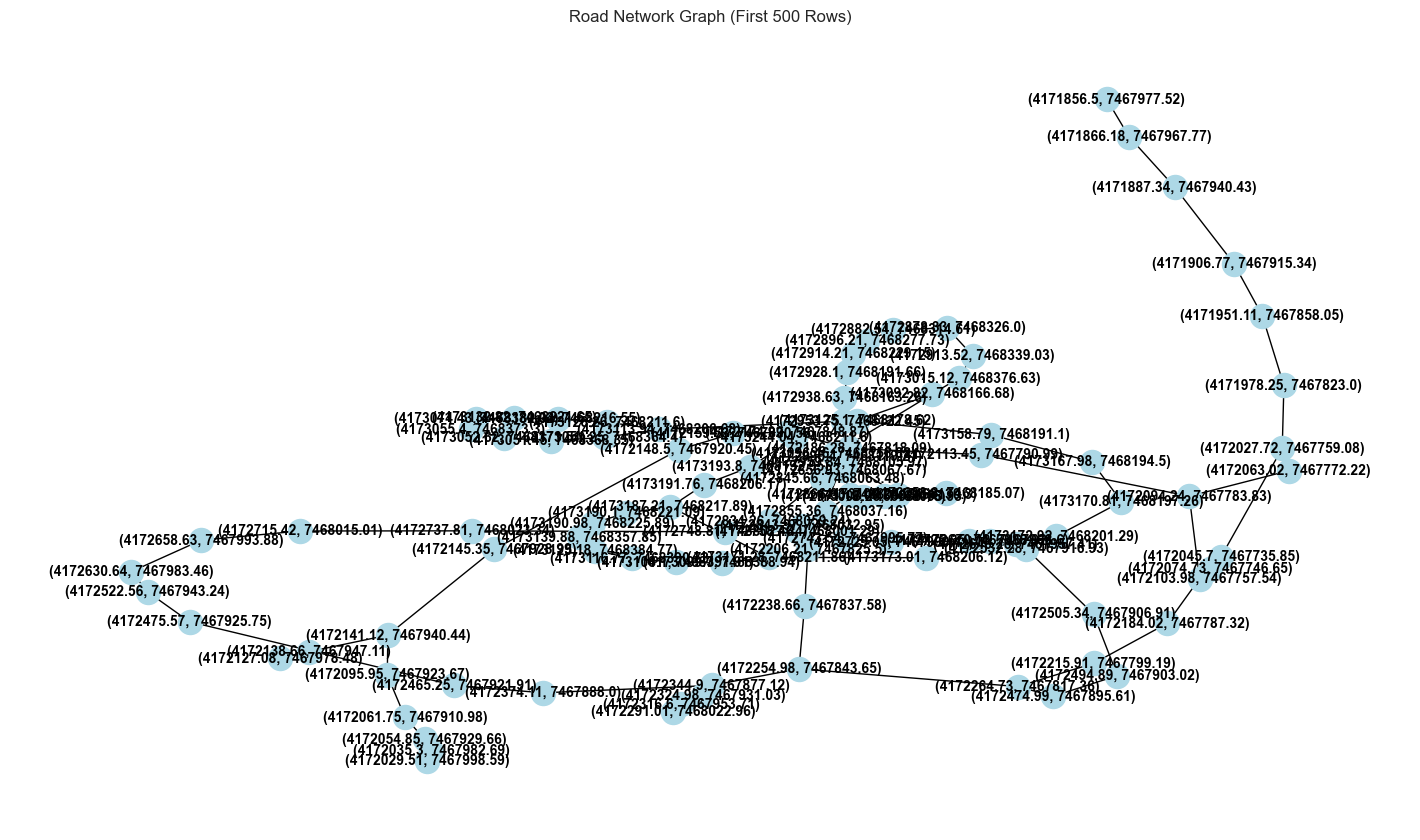

In [179]:
# Визуализация графа
plt.figure(figsize=(14, 8))
pos = nx.spring_layout(G_largest)
nx.draw(G_largest, pos, with_labels=True, node_color='lightblue',
        font_size=10, font_weight='bold',
        connectionstyle='arc3,rad=0.3')
plt.title('Road Network Graph (First 500 Rows)')
plt.axis('off')
plt.show()

In [180]:
# Шаг 5: Загрузка и очистка данных домов и ключевых точек
houses_orig = load_and_reproject(os.path.join(data_dir, "Дома_исходные.shp"), target_crs)
houses_orig = clean_geometries(houses_orig)

C:\Users\hedge\DataspellProjects\vklab_recsys\venv\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: C:\Users\hedge\DataspellProjects\cp_2024_graphs\Векторные данные\Дома_исходные.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


Файл C:\Users\hedge\DataspellProjects\cp_2024_graphs\Векторные данные\Дома_исходные.shp загружен успешно с 16386 записями.
Количество некорректных геометрий после исправления: 527
Некорректные геометрии найдены:
     Name        Type Caption    Purpose PostIndex  Elevation  Entrances  \
2    None  Жилые дома    None  Жилой дом    108803        9.0        2.0   
203  None  Жилые дома    None  Жилой дом    108820       13.0        3.0   
204  None  Жилые дома    None  Жилой дом    108820        9.0        8.0   
205  None  Жилые дома    None  Жилой дом    108820        9.0        1.0   
207  None  Жилые дома    None  Жилой дом    108820        9.0        1.0   

     Apartments    District        DistrictId  ... StreetId2 Number2 Street3  \
2          67.0  Коммунарка  4504209520926899  ...      None    None    None   
203       156.0  Коммунарка  4504209520926899  ...      None    None    None   
204       286.0  Коммунарка  4504209520926899  ...      None    None    None   
205        

In [181]:
# Загрузка ключевых точек: Выходы метро и Остановки ОТ
metro_exits = load_and_reproject(os.path.join(data_dir, "Выходы_метро.shp"), target_crs)
bus_stops = load_and_reproject(os.path.join(data_dir, "Остановки_ОТ.shp"), target_crs)
houses3 = load_and_reproject(os.path.join(data_dir, "House_1очередь_ЖК.shp"), target_crs)

Файл C:\Users\hedge\DataspellProjects\cp_2024_graphs\Векторные данные\Выходы_метро.shp загружен успешно с 7 записями.
Файл C:\Users\hedge\DataspellProjects\cp_2024_graphs\Векторные данные\Остановки_ОТ.shp загружен успешно с 61 записями.
Файл C:\Users\hedge\DataspellProjects\cp_2024_graphs\Векторные данные\House_1очередь_ЖК.shp загружен успешно с 45 записями.


In [182]:
# Фильтрация школ из House_3очередь_ЖК.shp
if 'Type' in houses3.columns:
    schools = houses3[houses3['Type'] == 'Школы']
else:
    print("Столбец 'Type' отсутствует в данных House_3очередь_ЖК.shp. Фильтрация школ невозможна.")
    schools = gpd.GeoDataFrame(columns=houses3.columns, crs=target_crs)

In [183]:
# Объединение ключевых точек
key_points = pd.concat([metro_exits, bus_stops, schools], ignore_index=True)
key_points = clean_geometries(key_points)
key_points.head()

Количество некорректных геометрий после исправления: 0
Все геометрии корректны.


,Number,Text,geometry,TrType,Name,TrStopId,Type,Purpose,Elevation,Entrances,Apartments,District,Street
0,7,Потапово,POINT (4173365.25 7470052.91),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,Потапово,POINT (4173441.38 7470047.67),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,Потапово,POINT (4173487.05 7469711.73),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Потапово,POINT (4173976.09 7469745.93),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Потапово,POINT (4174093.74 7469755.22),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [184]:
# Шаг 6: Привязка домов и ключевых точек к графу
houses_orig = bind_objects_to_graph(G_largest, houses_orig, object_type="Дом")
key_points = bind_objects_to_graph(G_largest, key_points, object_type="Ключевая точка")

Все Дом(ы) успешно привязаны к ближайшим узлам графа.
Все Ключевая точка(ы) успешно привязаны к ближайшим узлам графа.


In [185]:
# Шаг 7: Расчёт интенсивности пешеходов
houses_orig = calculate_intensity(houses_orig)

# Устранение предупреждения SettingWithCopyWarning с использованием .copy()
houses_orig = houses_orig.copy()

# Дополнительный вывод для проверки
print("Статистика по интенсивности:")
try:
    print(houses_orig[['intensity_children_pensioners', 'intensity_adults_public_transport', 'total_intensity']].describe())
except KeyError as e:
    print(f"Отсутствует столбец: {e}. Проверьте правильность расчёта интенсивности.")

# --- Пример Основного Процесса для Множественных Годов ---

Статистика по интенсивности:
       intensity_children_pensioners  intensity_adults_public_transport  \
count                     511.000000                         511.000000   
mean                       92.639237                         138.958855   
std                       112.249623                         168.374435   
min                         0.450000                           0.675000   
25%                        22.050000                          33.075000   
50%                        57.150000                          85.725000   
75%                       116.550000                         174.825000   
max                       697.950000                        1046.925000   

       total_intensity  
count       511.000000  
mean        231.598092  
std         280.624058  
min           1.125000  
25%          55.125000  
50%         142.875000  
75%         291.375000  
max        1744.875000  


In [186]:
 # Шаг 9: Идентификация узких мест и предложение новых пешеходных дорожек
# Привязка ключевых точек к графу для использования в маршрутизации
key_nodes = list(key_points['nearest_node'])

# Добавление атрибута 'total_intensity' к ребрам графа
for u, v, data in G_largest.edges(data=True):
    # Здесь предполагается, что интенсивность связана с ребром. 
    # В реальной задаче необходимо определить, как интенсивность распределяется по ребрам
    # Например, суммировать интенсивности домов, связанных с узлами u и v
    intensity_u = houses_orig[houses_orig['nearest_node'] == u]['total_intensity'].sum()
    intensity_v = houses_orig[houses_orig['nearest_node'] == v]['total_intensity'].sum()
    total_intensity = intensity_u + intensity_v
    G_largest[u][v]['total_intensity'] = total_intensity

bottlenecks = identify_bottlenecks(G_largest, P)

Найдено 12 узких мест с загруженностью выше 800 чел/ч.


In [187]:
# Шаг 10: Предложение новых путей (упрощенный пример)
new_paths = suggest_new_paths(G_largest, bottlenecks, key_points, num_suggestions=5)

Предлагается добавить ребро между (4172045.7, 7467735.85) и (4171978.25, 7467823.0)
Предлагается добавить ребро между (4172045.7, 7467735.85) и (4171978.25, 7467823.0)
Предлагается добавить ребро между (4173092.82, 7468166.68) и (4173106.26, 7468130.3)
Предложено 3 новых пешеходных дорожек.


In [188]:
# Округление координат новых путей для соответствия округленным узлам графа
precision = 2
new_paths = [(
    (round(edge[0][0], precision), round(edge[0][1], precision)),
    (round(edge[1][0], precision), round(edge[1][1], precision))
) for edge in new_paths]

In [189]:
# Шаг 11: Добавление новых ребер в граф
G_optimized = add_new_edges_to_graph(G_largest, new_paths)

Добавлено новое ребро между (4172045.7, 7467735.85) и (4171978.25, 7467823.0)
Ребро между (4172045.7, 7467735.85) и (4171978.25, 7467823.0) уже существует.
Добавлено новое ребро между (4173092.82, 7468166.68) и (4173106.26, 7468130.3)
Добавлено 2 новых ребер в граф.


In [190]:
for edge in new_paths:
    u, v = edge
    if G_optimized.has_edge(u, v):
        print(f"Ребро {edge} успешно добавлено.")
    else:
        print(f"Ребро {edge} не было добавлено.")

Ребро ((4172045.7, 7467735.85), (4171978.25, 7467823.0)) успешно добавлено.
Ребро ((4172045.7, 7467735.85), (4171978.25, 7467823.0)) успешно добавлено.
Ребро ((4173092.82, 7468166.68), (4173106.26, 7468130.3)) успешно добавлено.


In [191]:
 # Шаг 12: Пересчёт загруженности после оптимизации
overloaded_after = recalculate_load(G_optimized, P)

После оптимизации найдено 12 перегруженных участков.


C:\Users\hedge\DataspellProjects\vklab_recsys\venv\lib\site-packages\networkx\drawing\nx_pylab.py:305: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for connectionstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


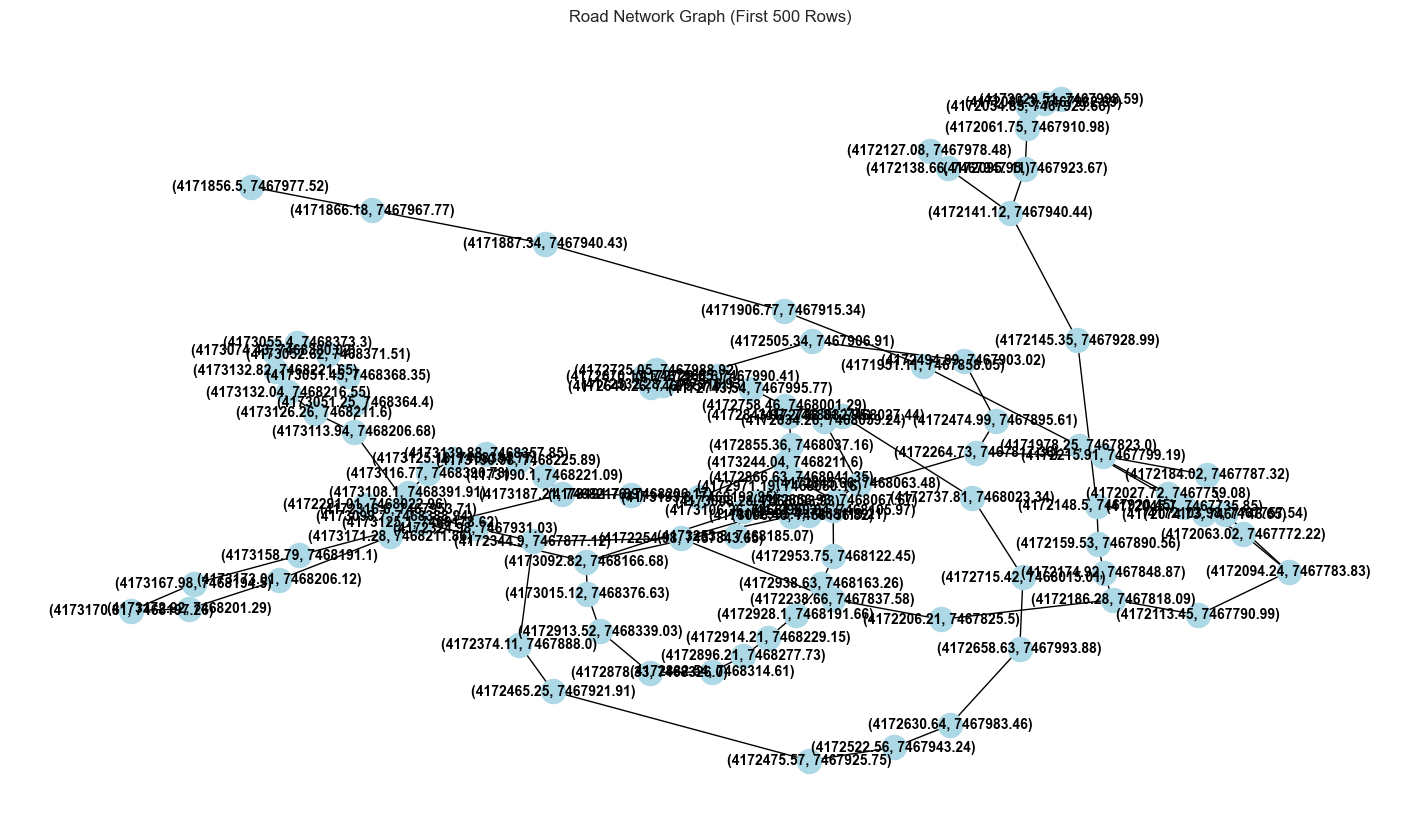

In [192]:
# Визуализация графа
plt.figure(figsize=(14, 8))
pos = nx.spring_layout(G_optimized)
nx.draw(G_optimized, pos, with_labels=True, node_color='lightblue',
        font_size=10, font_weight='bold',
        connectionstyle='arc3,rad=0.3')
plt.title('Road Network Graph (First 500 Rows)')
plt.axis('off')
plt.show()

In [193]:
# Шаг 13: Сохранение оптимизированного графа
save_versioned_graph(G_optimized, year=1, output_dir=versions_dir)

Дорожной граф сохранен как C:\Users\hedge\DataspellProjects\cp_2024_graphs\Векторные данные\Versions\Streets_1.shp


In [ ]:
# # Шаг 14: Визуализация результатов пешеходной доступности
# visualize_accessibility(G_optimized, houses_orig, key_points, 1)

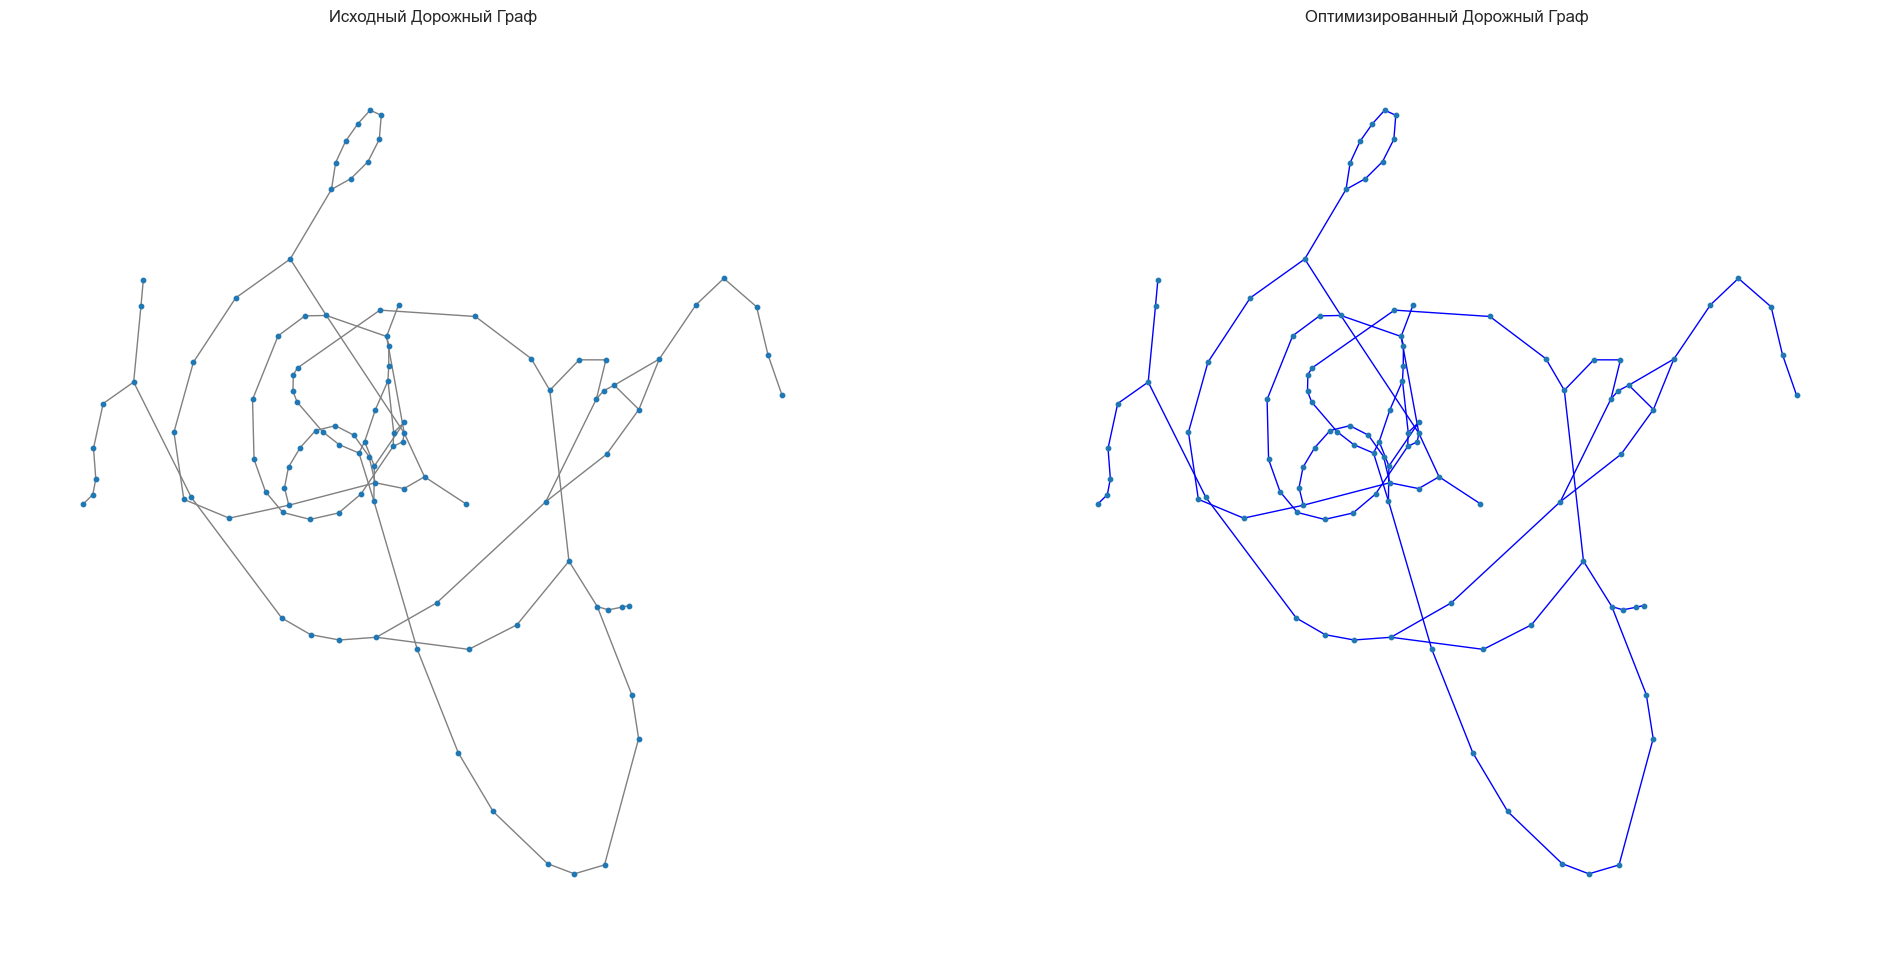

In [195]:
# Шаг 15: Визуализация исходного и оптимизированного графа
visualize_optimized_graph(G_largest, G_optimized)